## Problem 1

Suppose whether it is sunny or not in Charlottesville depends on the weather of the last three days. Show how this can be modeled as a Markov chain.

### Answer:

Suppose a weather value of 1 means sunny and 0 means rain. We define the state as the vector weather values of the last three days. Let $x_t$ be this vector at time $t$, so $x_t = (0,0,1)$ means that it rained at times $t-2$ and $t-1$ and was sunny at time $t$. Thus each $x_t, t = 1, \ldots, T$ takes one of 8 vector values $(i_1,i_2,i_3), i_j \in \{0,1\}, j =1,2,3$. Since the weather today depends on the weather values for the last three days, then $Pr(x_t= k_t| x_{t-1} = k_{t-1}, \ldots, x_1 = k_1) = Pr(x_t= k_t| x_{t-1} = k_{t-1})$ for $k_m \in (i_1,i_2,i_3), i_j \in \{0,1\}, j =1,2,3$. This means $x_t, t =1, \ldots, T$ is a Markov chain.

## Problem 2

Let $X \sim N(\mu, \Sigma)$ where $\mu = (1,1)$ and 

$\begin{equation*}
\Sigma = 
\begin{bmatrix}
1 & -0.5 \\
-0.5 & 1
\end{bmatrix}
\end{equation*}$

Use  numpy and scipy to implement a Gibbs sampling algorithm for this 2D Gaussian. Show three runs of you algorithm with 100 samples past burn-in  as 1D scatter plots in each of the two dimensions overlaid on the plots of the actual marginal distributions.

### Answer:

Let 
$p(\mathbf{x})$  be the target distribution and recall that it is a bivariate Gaussian. This means that 

$\begin{align*}
    p(\mathbf{x}) & \propto \exp \left( -\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right) \\
    & = \exp \left( -\frac{1}{2} \begin{bmatrix}x_1 - \mu_1 & x_2 - \mu_2\end{bmatrix} \begin{bmatrix}\Sigma^{-1}_{11} & \Sigma^{-1}_{12} \\ \Sigma^{-1}_{21} & \Sigma^{-1}_{22}\end{bmatrix} \begin{bmatrix}x_1 - \mu_1 \\ x_2 - \mu_2 \\ \end{bmatrix} \right)
\end{align*}$

To simplify the notation let  $\alpha = x_1 - \mu_1$ and $\beta = x_2 - \mu_2$, so:

$\begin{align*}
    & = \exp \left( -\frac{1}{2} \begin{bmatrix}\alpha & \beta\end{bmatrix} \begin{bmatrix}\Sigma^{-1}_{11} & \Sigma^{-1}_{12} \\ \Sigma^{-1}_{21} & \Sigma^{-1}_{22}\end{bmatrix} \begin{bmatrix}\alpha  \\ \beta \\ \end{bmatrix} \right) \\
    & =  \exp \left( -\frac{1}{2} \begin{bmatrix} \alpha \Sigma^{-1}_{11} + \beta \Sigma^{-1}_{21} &, \alpha \Sigma^{-1}_{12} + \beta \Sigma^{-1}_{22} \end{bmatrix} \begin{bmatrix}\alpha  \\ \beta \\ \end{bmatrix} \right) \\   
    & =  \exp -\frac{1}{2}\left(  \alpha(\alpha \Sigma^{-1}_{11} + \beta \Sigma^{-1}_{21}) + \beta(\alpha \Sigma^{-1}_{12} + \beta \Sigma^{-1}_{22}) \right) \\ 
    & = \exp \left( -\frac{1}{2} (\alpha^2 \Sigma^{-1}_{11} + \alpha\beta \Sigma^{-1}_{21} + \alpha\beta \Sigma^{-1}_{12} + \beta^2 \Sigma^{-1}_{22}) \right) 
\end{align*}$

So
\begin{equation} \label{eq:Gaussian}
 p(\mathbf{x})  \propto \exp \left( -\frac{1}{2} (\alpha^2 \Sigma^{-1}_{11} + \alpha\beta \Sigma^{-1}_{21} + \alpha\beta \Sigma^{-1}_{12} + \beta^2 \Sigma^{-1}_{22}) \right) 
\end{equation}


For Gibb's sampling we fix one variable and sample according to the distribution of the other. We continue through all variables. In this case there are only 2 variables. Suppose we start with $x_{1}$ then we fix $x_{2}$ and sample according to  $p(x_1 \mid x_2 = k)$ for some constant, $k$. This is a univariate Gaussian (a slice across any dimension of a multivariate Gaussian is also Gaussian). So it has the form 

\begin{equation}\label{eq:UniGaussian}
p(x_1 \mid x_2 = k)  = \frac{1}{\sigma \sqrt{2\pi}}\exp \left(\frac{-1}{2\sigma^2}(x_{1}-\mu)^2 \right)
\end{equation}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc3 as pm
import arviz as az
import pandas as pd
import scipy.linalg as la


az.style.use('arviz-darkgrid')

In [2]:
# True mu, covariance matrix
mu = np.array( [1, 1] )
cov = np.array( [[  1, -.5],
                 [ -.5,  1]] )

# True bivariate and marginal distributions
true_p = st.multivariate_normal(mean = mu, cov=cov)
true_marginal_p_x1 = st.norm(loc = mu[0], scale = cov[0,0])
true_marginal_p_x2 = st.norm(loc = mu[1], scale = cov[1,1])

# Number of chains, although only 1 was required
M = 3

In [4]:
# Get the values for the matrix inverse of the covariance matrix (precision)

la.inv(cov)

array([[1.33333333, 0.66666667],
       [0.66666667, 1.33333333]])

Substituting the particular values of $\Sigma^{-1}$ at this stage simplifies the problem:

\begin{align}
    & = \exp \left( -\frac{1}{2} (\frac{4}{3} \alpha^2 + 2\frac{2}{3} \alpha\beta + \frac{4}{3} \beta^2 ) \right) \\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( \alpha^2 + \alpha\beta + \beta^2 ) \right) \\
\end{align}

Now, find $p(x_1 \mid x_2 = k)$, i.e., the conditional distribution of $x_1$ for some fixed value of $x_2$:

\begin{align}
    p(x_1 \mid x_2 = k) & \propto \exp \left( -\frac{1}{2} \frac{4}{3} ( \alpha^2 + \alpha\beta + \beta^2 ) \right) \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( (x_1 - \mu_1)^2 + (x_1 - \mu_1)\beta + \beta^2 ) \right) & \textrm{by substituting }\alpha \\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( (x_1 - 1)^2 + (x_1 - 1)\beta + \beta^2 ) \right) & \textrm{by substituting }\mu\\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( x_1^2 - 2x_1 + 1 + \beta x_1 - \beta + \beta^2 ) \right) \\
    & = \exp \left( -\frac{1}{2} \frac{4}{3} ( x_1^2 + (\beta-2)x_1 + (\beta^2 - \beta + 1)) \right) \\
    & \propto \exp \left( -\frac{1}{2} \frac{4}{3} \left( x_1^2 + \frac{\beta-2}{2} \right)^2 + \text{Const}\right) & \textrm{by completing the square}\\
\end{align}

Where $\text{Const} = \frac{3\beta^2}{4}$. So, $p(x_1 \mid x_2 = k)$ is a univariate Gaussian, a function of the form $\exp \left(\frac{-1}{2\sigma^2}(x-\mu)^2 \right)$, for 
\begin{align}
\mu &= -\frac{\beta-2}{2} = -\frac{(k-1)-2}{2} = \frac{3-k}{2} \\
\sigma^2 &= \frac{3}{4}
\end{align}

Now, find $p(x_2 \mid x_1 = k)$ using very similar derivation:

\begin{align}
    p(x_2 \mid x_1 = k) & \propto \exp \left( -\frac{1}{2} \frac{4}{3} ( \alpha^2 + \alpha\beta + \beta^2 ) \right) \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( ( \alpha^2 + \alpha(x_2 - \mu_2) + (x_2 - \mu_2)^2 ) \right) & \textrm{by substituting }\alpha \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( ( \alpha^2 + \alpha(x_2 - 1) + (x_2 - 1)^2 ) \right) & \textrm{by substituting }\mu \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( x_2^2 - 2x_2 + 1 + \alpha x_2 - \alpha + \alpha^2   ) \right) \\
    & =\exp \left( -\frac{1}{2} \frac{4}{3} ( x_2^2 + (\alpha-2) x_2  + (\alpha^2 - \alpha + 1)   ) \right) \\
    & \propto \exp \left( -\frac{1}{2} \frac{4}{3} \left( x_2^2 + \frac{\alpha-2}{2} \right)^2 + \text{Const}\right) & \textrm{by completing the square}\\
\end{align}

So $p(x_2 \mid x_1 = k)$ is _also_ a univariate Gaussian, a function of the form $\exp \left(\frac{-1}{2\sigma^2}(x-\mu)^2 \right)$, for 
\begin{align}
\mu &= -\frac{\alpha-2}{2} = -\frac{(k-1)-2}{2} = \frac{3-k}{2} \\
\sigma^2 &= \frac{3}{4}
\end{align}

In [5]:
# Define the conditional distributions, as derived above.
# Note that scipy uses standard deviation, not variance, for "scale"
def p_x1_x2(x2):
    return st.norm(loc = (3-x2)/2, scale = (3/4)**.5)
def p_x2_x1(x1):
    return st.norm(loc = (3-x1)/2, scale = (3/4)**.5)

# Draw a Gibbs sample, given current state x.
# Loop over each component, sampling from the conditional distributions
def gibbs(x):
    x[0] = p_x1_x2(x[1]).rvs(1)
    x[1] = p_x2_x1(x[0]).rvs(1)
    
# Calculate Rhat to determine if the chain is converging 
def Rhat(chains):
    N = len(chains[0]) # assume all chains of equal length
    
    theta_bar_j = np.array([c.mean() for c in chains])
    theta_dbar = theta_bar_j.mean()
    
    B = N / (M-1) * ( (theta_bar_j-theta_dbar)**2 ).sum()
    
    W = np.array( [c.var() for c in chains] )
    
    varhat_theta = (1 - 1/N) * W + 1/N * B
    
    Rhat = (varhat_theta/W)**.5
    
    # return largest Rhat (Rhat is calculated for each chain)
    return max(Rhat)

In [6]:
# Pick initial values that could be almost anywhere, pretending that the true ones are unknown
init = st.cauchy()

# Initialize the chain states (just current state)
chains  = [st.norm.rvs((1,2)), 
           st.norm.rvs((1,2)), 
           st.norm.rvs((1,2))]

# Initialize the samples (include previous states)
samples = [np.array(chains[0]),
           np.array(chains[1]),
           np.array(chains[2])]
samples = [s.reshape((1,2)) for s in samples]

In [7]:
# Run until convergence is reached
i = 0
while True:
    
    # Run Gibbs sampler for each chain, one iteration
    for j in range(M):
        gibbs(chains[j])
        samples[j] = np.concatenate((samples[j], chains[j].reshape((1,2))))
       
    # Calculate the Rhat for each parameter, then take the larger of the two
    Rhat_x1 = Rhat([s[:, 0] for s in samples])
    Rhat_x2 = Rhat([s[:, 1] for s in samples])
    max_Rhat = max(Rhat_x1, Rhat_x2)

    # If it's greater than 1.2, continue iterating.
    # Otherwise, break. The variable i will be the iteration when convergence was reached
    i += 1
    print("Iteration {0}, largest Rhat = {1}".format(i, max_Rhat))   
    if max_Rhat <= 1.2:
        print("Convergence reached (Rhat <= 1.2)...")
        break

Iteration 1, largest Rhat = 3.786196088672888
Iteration 2, largest Rhat = 1.4150291103977333
Iteration 3, largest Rhat = 1.307091507766882
Iteration 4, largest Rhat = 0.985306174180573
Convergence reached (Rhat <= 1.2)...


In [8]:
# Generate N samples
print("Sampling...")

# Now that the three chains have converged, draw N samples from each
N = 10000
for _ in range(N):
    
    # For each chain,
    for j in range(M):
        
        # Run Gibbs sampling and store the sample
        gibbs(chains[j])
        samples[j] = np.concatenate((samples[j], chains[j].reshape((1,2))))
        
# Discard the samples from before convergence
for j in range(M):
    samples[j] = samples[j][(i+1):, :]

Sampling...


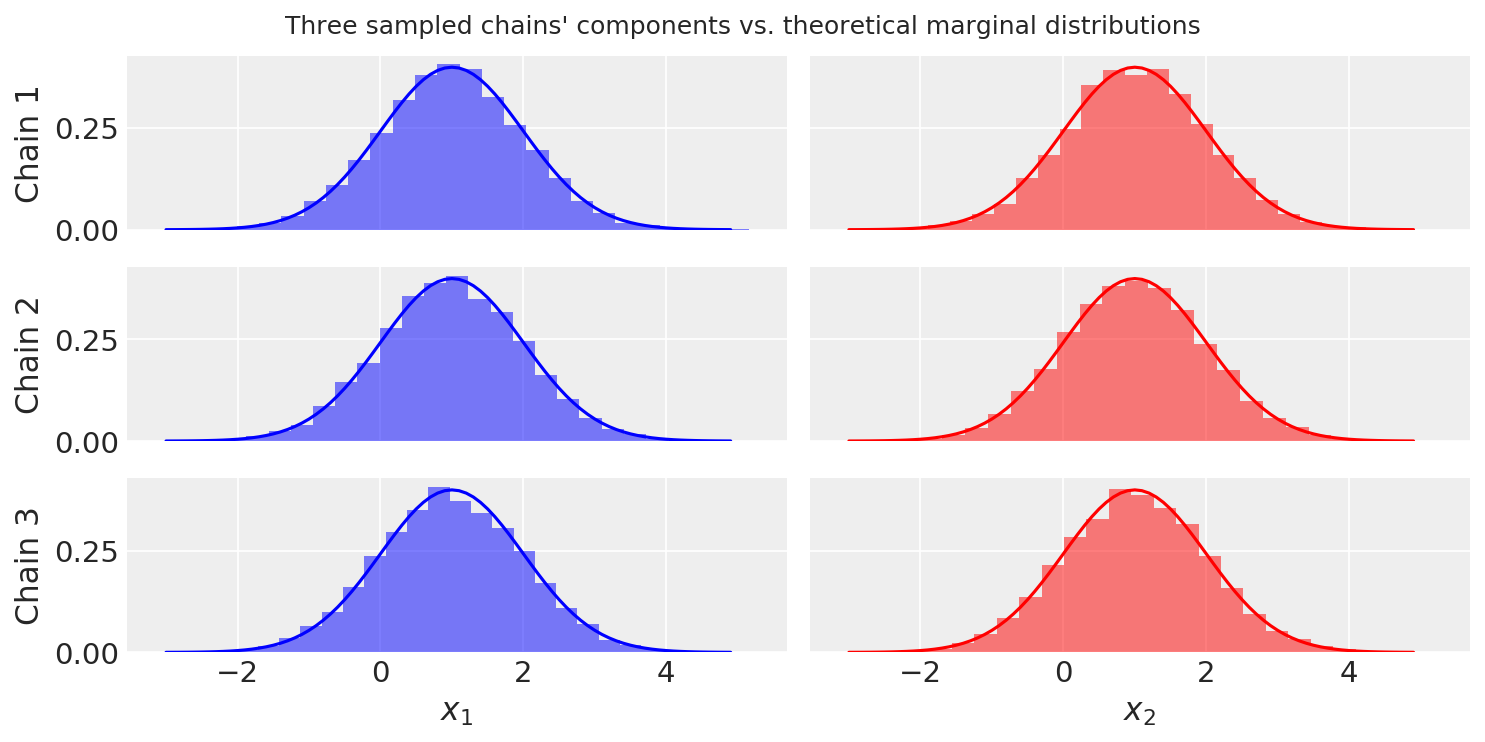

In [10]:
# Plot the three chains' samples for each variable against the true marginal distributions
# As noted two cells above ("Generate N samples..."), there are N = 10000 samples in each plot
# This is 2 orders of magnitude more than required.
# Also, burn-in was determined by when Rhat <= 1.2

support = np.arange(-3, 5, 0.1)

fig, axes = plt.subplots(nrows=3, ncols = 2, figsize=(10,5), dpi=150, sharex=True, sharey=True)
for j in range(M):
    for k, color, true_marginal in zip(range(2), ['blue', 'red'], [true_marginal_p_x1, true_marginal_p_x2]):
        
        axes[j,k].hist(samples[j][:,k], density=True, bins=25, alpha=0.5, color=color)
        axes[j,k].plot(support, true_marginal.pdf(support), color=color)
        
for k in range(2):
    axes[-1,k].set_xlabel("$x_%d$" % (k+1))
    
for j in range(M):
    axes[j,0].set_ylabel("Chain %d" % (j+1))
        
plt.suptitle("Three sampled chains' components vs. theoretical marginal distributions")
plt.tight_layout()
plt.subplots_adjust(top=.925)
plt.show()

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


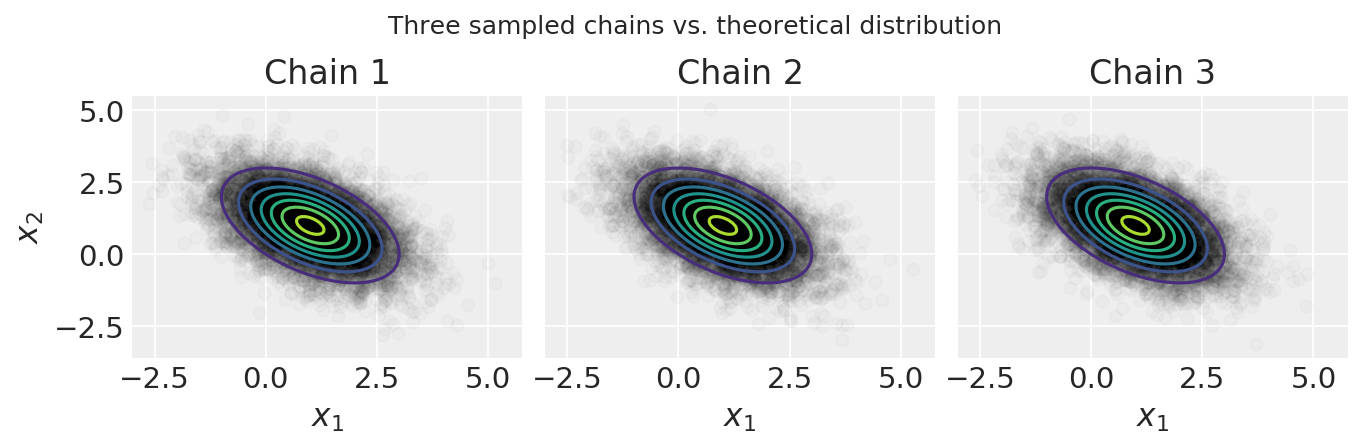

In [9]:
# For extended viewing (not required in the assignment), 
# plot each chain against the true bivariate Gaussian distribution
# Use this to check the results, in addition to the required plots (above)

n = 100
x = np.mgrid[(1-4):(1+4):(n*1j)]
y = np.mgrid[(1-4):(1+4):(n*1j)]

fig, axes = plt.subplots(nrows=1, ncols = 3, figsize=(9,3), dpi=150, sharex=True, sharey=True)
z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        z[j, i] = true_p.pdf( (x[i], y[j]) )
            
for j in range(M):
    axes[j].scatter(samples[j][:,0], samples[j][:,1], color='black', alpha=0.015)
    axes[j].contour(x, y, z)
    axes[j].set_title("Chain %d" % (j+1))
    axes[j].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
    
plt.suptitle("Three sampled chains vs. theoretical distribution")
plt.tight_layout()
plt.subplots_adjust(top=.8)
plt.show()

## Problem 3

With the CHD data set (CHDdata.csv ) from  Homework 2 develop a sampling based estimate for the posterior distributions of the parameters in a main effects logistic regression model. Use all predictor variables in the data set and standardize all of the numeric, continuous predictors using the mean and standard deviation. 

- Use Gaussian or Cauchy priors with hyperparameters appropriate for uninformed priors and show the graphical representation of your model (you should use graphviz for this).
- Show the summary table and trace plots from the sampling and briefly say what they mean for your results.
- Provide forest plots of the parameters and discuss what these results imply for the relevant predictor variables and the overall model.

In [199]:
# Load the data

path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "CHDdata.csv"
data = pd.read_csv(path+file)

# Numeric predictors
numeric_predictors = ["sbp","tobacco","ldl","adiposity","typea","obesity","alcohol","age"]
n = data.shape[0]

# Numeric, categorical predictors and response, y`

x_num = data[numeric_predictors]
x_cat = data['famhist']
y = data['chd']

all_predictors = numeric_predictors
all_predictors.append('famhist')

# No. of predictors
k = len(all_predictors)

# Standardize numeric columns, to mean 0 variance 1
mean = x_num.mean()
std = x_num.std()
x_num = np.array((x_num - mean) / std)

# Convert categorical predictor column to a dummy variable
# + 0 forces numeric type
x_cat = np.array(data['famhist'] == 'Present').reshape((n,1))

# Put them into one data matrix

X = np.concatenate((x_num, x_cat), axis = 1)


In [34]:
# Build the model with priors and run the sampling
with pm.Model() as chd_model:
    
    # Intercept term & prior
    β0 = pm.Normal('β0', mu=0, sd=1)
    # Beta coefficients for predictor variables & priors
    β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    
    # Calculate the logit 
    μ = β0 + pm.math.dot(X,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    # Pass the logits to a Bernoulli outcome, with the observed data
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=y) 
    
    # Sample
    trace_main = pm.sample(10000, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β, β0]


Sampling 8 chains for 1_000 tune and 10_000 draw iterations (8_000 + 80_000 draws total) took 67 seconds.


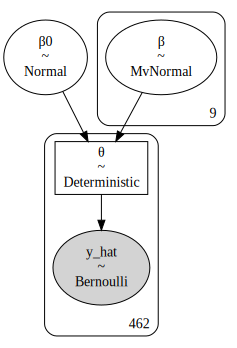

In [35]:
# The graphical model
pm.model_to_graphviz(chd_model)

In [81]:
# Results in table
with chd_model:
    main_idata = az.from_pymc3(trace_main)
az.summary(main_idata, var_names=['β0','β'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,-1.23,0.16,-1.54,-0.93,0.0,0.0,88862.99,87708.72,88952.04,65100.39,1.0
β[0],0.14,0.12,-0.08,0.36,0.0,0.0,127768.75,70186.52,127815.19,59498.67,1.0
β[1],0.37,0.12,0.14,0.60,0.0,0.0,120155.79,105148.00,120468.14,64810.95,1.0
β[2],0.37,0.12,0.14,0.60,0.0,0.0,126340.00,107441.72,126576.28,60409.85,1.0
β[3],0.15,0.22,-0.27,0.57,0.0,0.0,79507.06,54503.04,79510.24,62524.56,1.0
β[4],0.39,0.12,0.17,0.62,0.0,0.0,123071.24,109098.06,123178.48,61409.96,1.0
β[5],-0.27,0.18,-0.61,0.08,0.0,0.0,88316.81,72780.55,88429.75,63892.34,1.0
β[6],0.00,0.11,-0.20,0.21,0.0,0.0,119075.66,37255.95,119247.09,61297.58,1.0
β[7],0.66,0.18,0.32,0.98,0.0,0.0,94515.70,91219.40,94533.58,63704.43,1.0
β[8],0.87,0.22,0.45,1.29,0.0,0.0,88329.80,85548.70,88338.11,65435.28,1.0


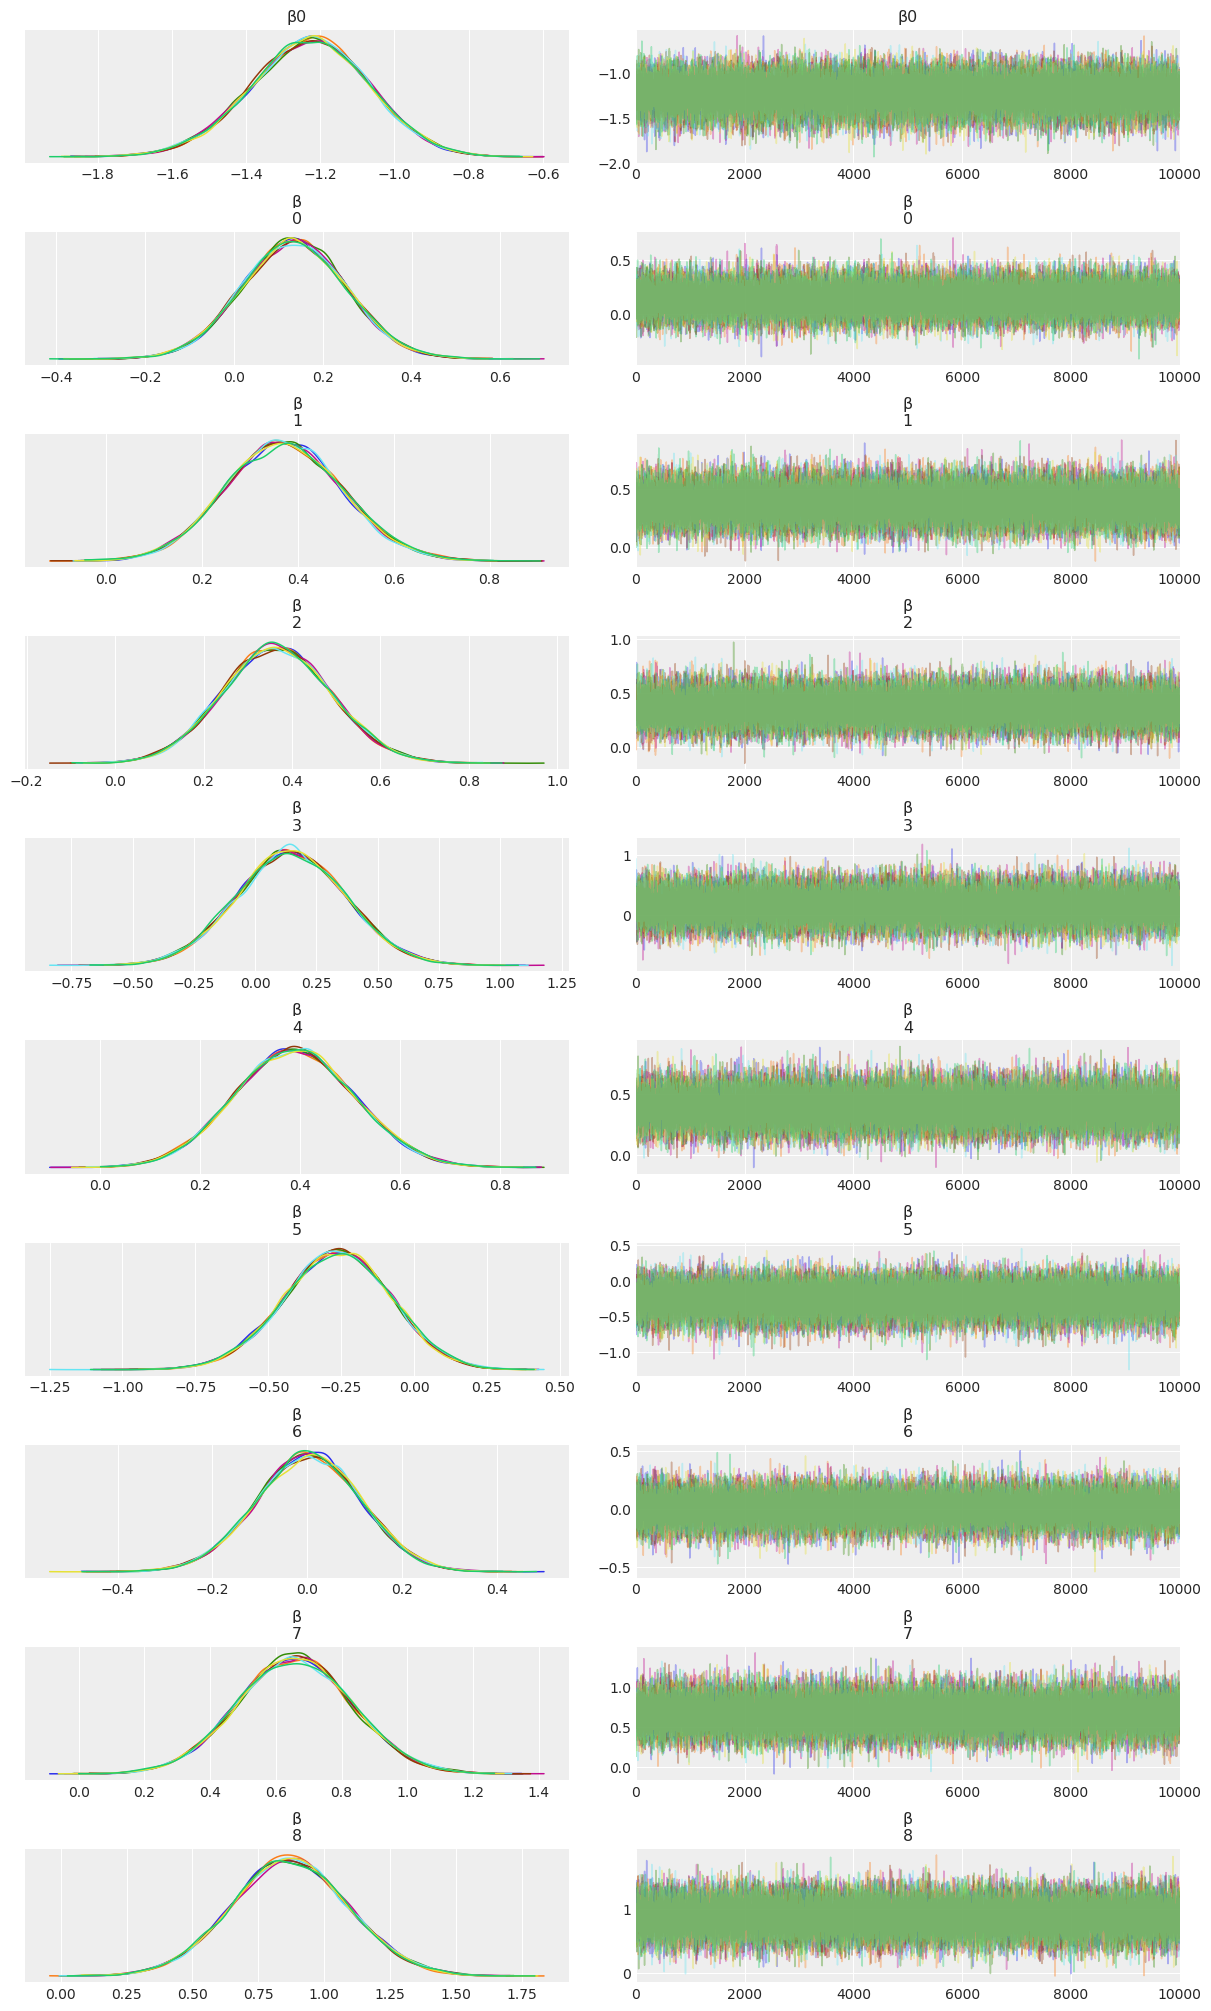

In [78]:
# Trace plots
with chd_model:
    az.plot_trace(trace_main, var_names=['β0','β'])

The trace plots show good covergence and the $\hat{R} = 1$ for all parameters. So we can be confident in our posterior estimates.

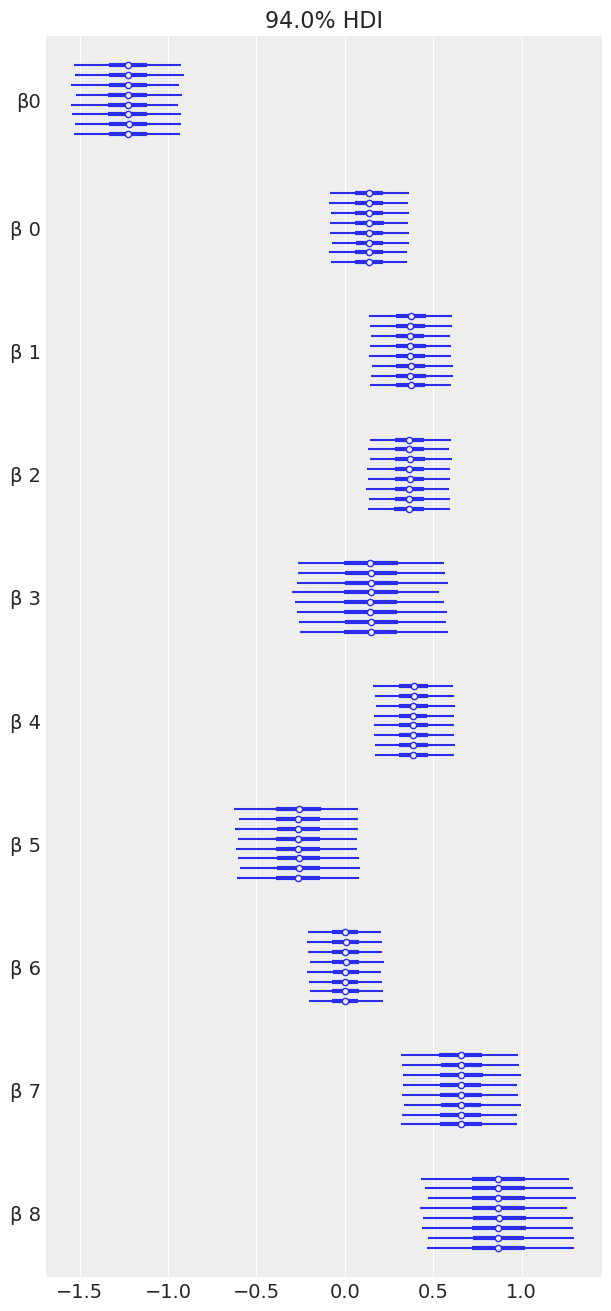

In [59]:
with chd_model:
    pm.forestplot(trace_main, var_names=['β0','β'])

In [63]:
pd.DataFrame(all_predictors)

,0
0,sbp
1,tobacco
2,ldl
3,adiposity
4,typea
5,obesity
6,alcohol
7,age
8,famhist


Based on the forest plots, the variables sdp, adiposity, obesity and alcohol are not significant in the main effects model at p < 0.05

/Users/donaldbrown/opt/anaconda3/envs/Bayes/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


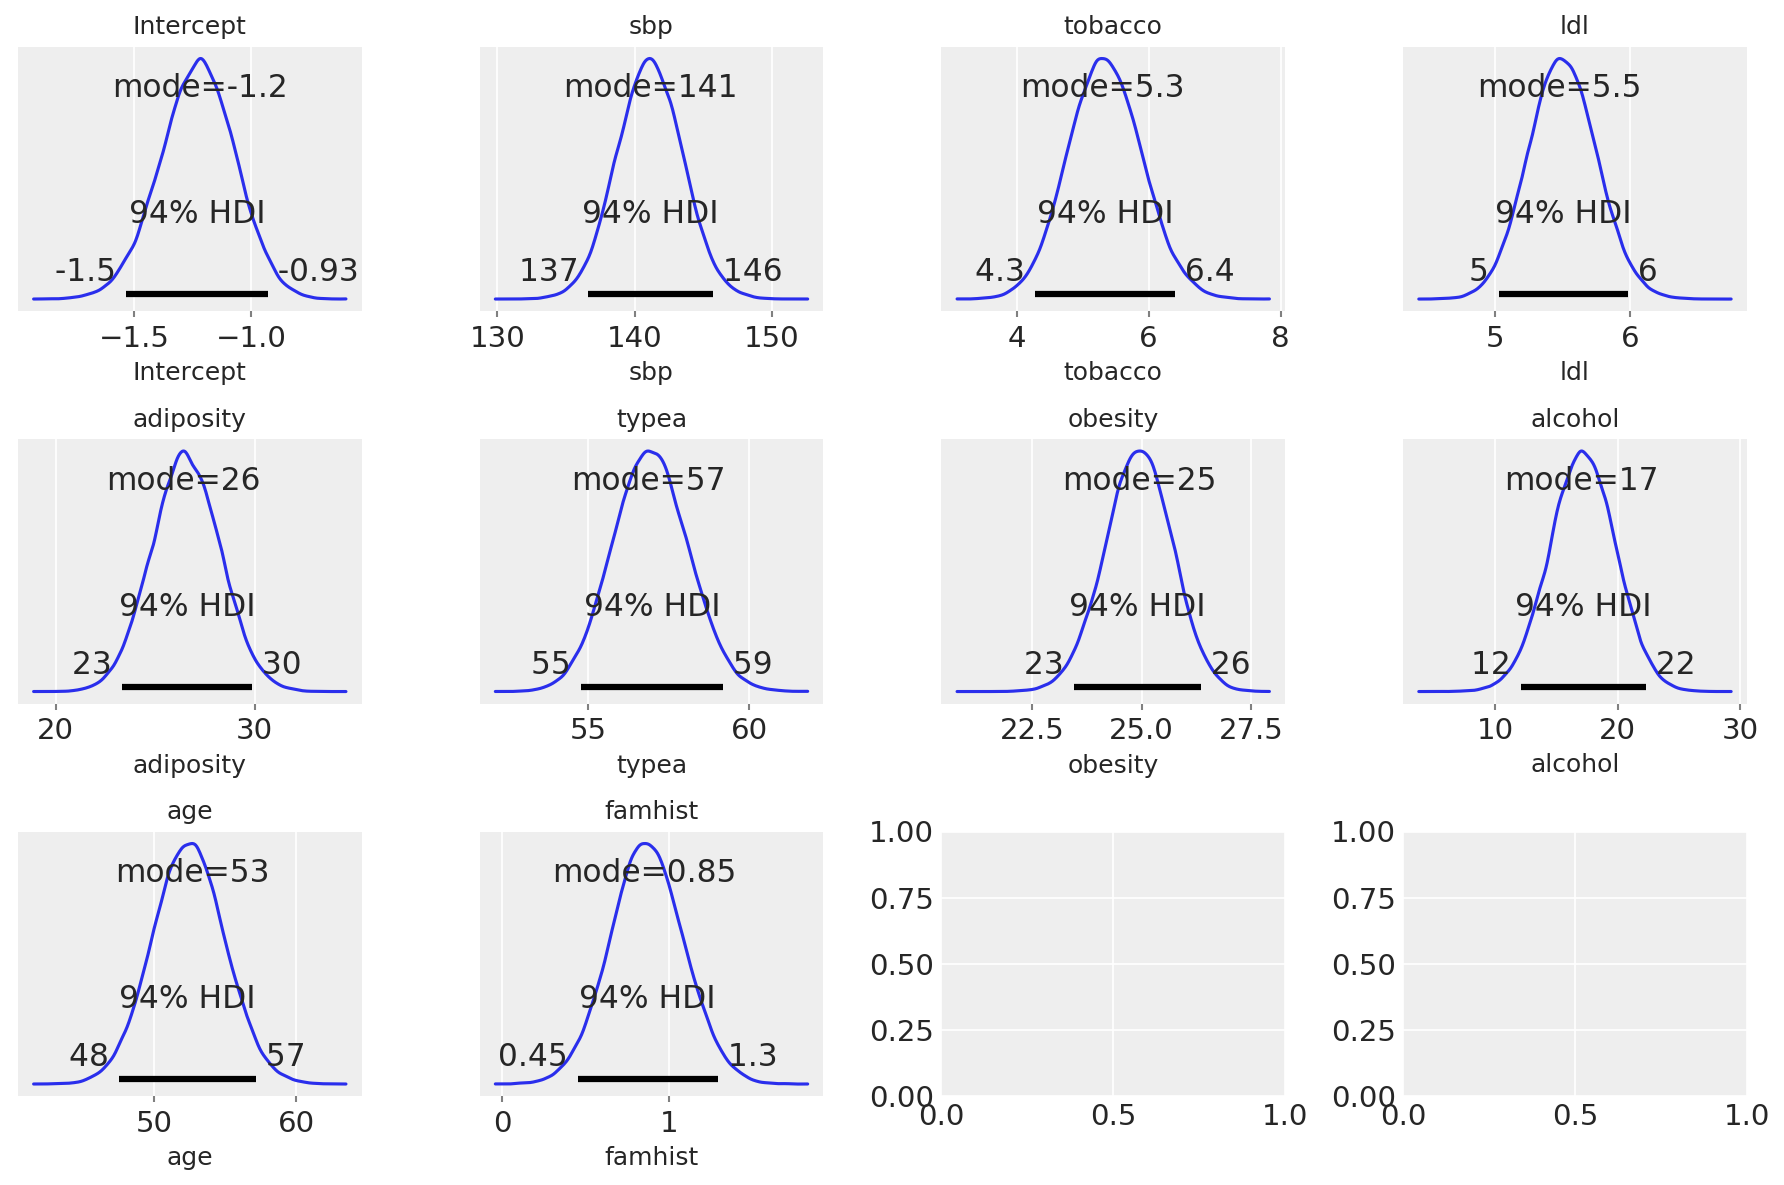

In [54]:
# Not required but additional plots of the coefficients
# Transform parameters back to original scale
burnin = 100
intercept = trace_main['β0'][burnin:]
beta = trace_main['β'][burnin:]
for i in range(k-1):
    beta[:, i] = beta[:, i] * std[i] + mean[i]

# Plot posteriors

fig, axes = plt.subplots(3,4, figsize=(12,8), dpi=150)

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept] + [beta[:,i] for i in range(k)],
                               ['Intercept'] + all_predictors,
                               ['Intercept'] + all_predictors):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)

plt.tight_layout()

## Problem 4

With the data set bangladesh.csv develop a pooled, a no-pooled, and a hierarchical model for all districts to predict contraception usage. Use only district and age.centered as predictor variables. Plot each of these predictions with age.centered on the x-axis and the expected proportion of women using contraception on the y-Axis with overlaid plots for the districts. Briefly explain these results.


In [103]:
path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "bangladesh.csv"
data = pd.read_csv(path+file)
# Predictor variables
age = data['age.centered']
contraception = data['use.contraception']
# grouping or hierarchical variable
districts = data['district'].unique()
ndistricts = len(districts)

In [104]:
data.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


In [106]:
# Load data

path = "/Users/donaldbrown/Dropbox/department/Classes/Data/"
file = "bangladesh.csv"
data = pd.read_csv(path+file)
# Predictor variables
age = data['age.centered']
contraception = data['use.contraception']
# grouping or hierarchical variable
districts = data['district'].unique()
ndistricts = len(districts)

# lookup table (dict) for each district
district_lookup = dict(zip(districts, range(ndistricts)))
district  = data["district_code"] = data.district.replace(district_lookup).values

In [107]:
# Complete pooling model

with pm.Model() as pooled_model:
    β = pm.Normal('β', 0, sd=1e5, shape=2)
    μ = β[0] + β[1]*age
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=contraception) 
    # Run sampling
    pooled_trace = pm.sample(10000, cores = 4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 33 seconds.


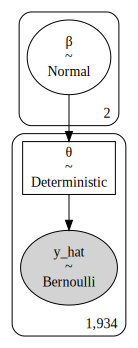

In [84]:
# Graph of pooled model

pm.model_to_graphviz(pooled_model)

In [88]:
# Summary of results
with pooled_model:
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2, var_names = ['β'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],-0.44,0.05,-0.53,-0.35,0.0,0.0,35329.82,35060.01,35338.85,28708.52,1.0
β[1],0.01,0.01,-0.00,0.02,0.0,0.0,36305.90,30900.99,36330.55,29253.94,1.0


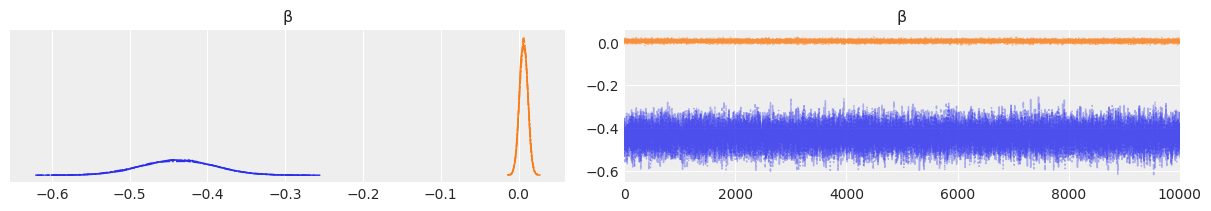

In [89]:
with pooled_model:
    pm.traceplot(pooled_trace, var_names = ['β'])

In [100]:
# Logistic

def logistic(x):
    return ( 1 / (1+ np.exp(-x)))

Text(0.5, 1.0, 'Pooled Model')

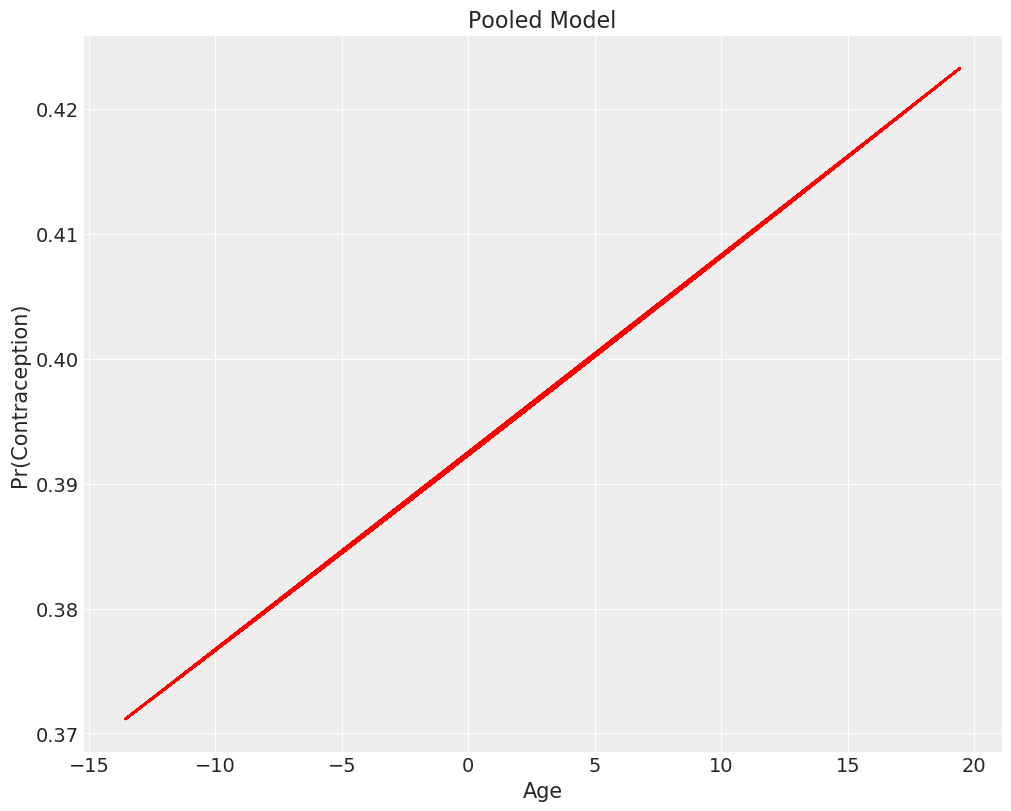

In [112]:
# Plot of the pooled model
beta = np.mean(pooled_trace['β'], axis=0)
plt.figure(figsize = (10,8))
#plt.scatter(age, contraception)
#xvals = np.linspace(-20, 20)
plt.plot(age, logistic(beta[0] + beta[1]*age), 'r--');
plt.xlabel("Age")
plt.ylabel("Pr(Contraception)")
plt.title("Pooled Model")

In [109]:
# Unpooled Model

with pm.Model() as unpooled_model:
    
    β0 = pm.Normal('β0', 0, sd=100, shape=ndistricts)
    β1 = pm.Normal('β1', 0, sd=100)
    
    μ = β0[district] + β1*age
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=contraception)
    
    # Sample the posterior
    unpooled_trace = pm.sample(draws=1000, cores =8)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [β1, β0]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.
There were 717 divergences after tuning. Increase `target_accept` or reparameterize.
There were 930 divergences after tuning. Increase `target_accept` or reparameterize.
There were 853 divergences after tuning. Increase `target_accept` or reparameterize.
There were 779 divergences after tuning. Increase `target_accept` or reparameterize.
There were 918 divergences after tuning. Increase `target_accept` or reparameterize.
There were 842 divergences after tuning. Increase `target_accept` or reparameterize.
There were 777 divergences after tuning. Increase `target_accept` or reparameterize.
There were 781 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


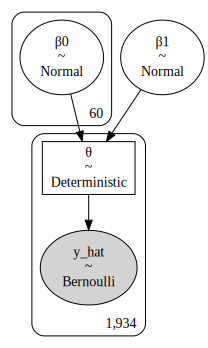

In [110]:
# Graph the unpooled model
pm.model_to_graphviz(unpooled_model)

In [111]:
# Summary of results
with unpooled_model:
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2, var_names = ['β0','β1'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0[0],-1.09,0.22,-1.50,-0.68,0.01,0.00,1759.70,1722.84,1764.29,2270.03,1.00
β0[1],-0.63,0.49,-1.52,0.34,0.01,0.01,1871.25,1729.35,1881.47,2222.86,1.00
β0[2],80.15,58.89,1.74,188.77,1.83,1.30,1031.20,1031.20,1152.72,1591.83,1.01
β0[3],-0.02,0.37,-0.70,0.68,0.01,0.01,1719.42,1719.42,1722.80,2149.45,1.00
β0[4],-0.58,0.34,-1.18,0.10,0.01,0.01,1577.94,1577.94,1574.85,2391.41,1.00
β0[5],-0.90,0.27,-1.41,-0.40,0.01,0.00,1704.60,1696.03,1707.27,2375.35,1.00
β0[6],-0.99,0.53,-2.06,-0.06,0.01,0.01,1817.25,1678.26,1847.89,2195.24,1.01
β0[7],-0.52,0.35,-1.19,0.11,0.01,0.01,1558.01,1525.88,1563.83,2111.12,1.00
β0[8],-0.86,0.49,-1.75,0.10,0.01,0.01,1402.13,1394.62,1405.76,2084.98,1.01
β0[9],-3.06,1.29,-5.43,-0.92,0.04,0.03,950.80,819.60,1129.84,1062.41,1.00


Text(0.5, 1.0, 'Unpooled Model')

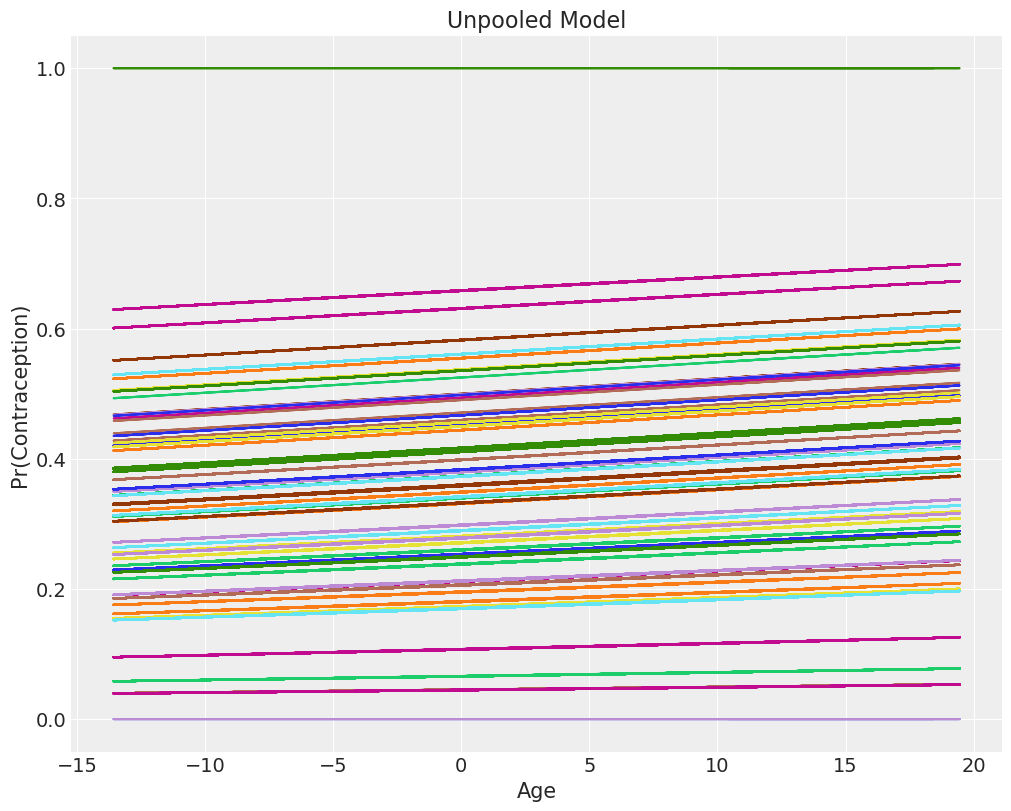

In [114]:
# Plot of the unpooled model
beta0 = np.mean(unpooled_trace['β0'], axis=0)
beta1 = np.mean(unpooled_trace['β1'], axis=0)
plt.figure(figsize = (10,8))
for beta0i in beta0:
    plt.plot(age, logistic(beta0i + beta1*age))

plt.xlabel("Age")
plt.ylabel("Pr(Contraception)")
plt.title("Unpooled Model")

<Figure size 600x1400 with 0 Axes>

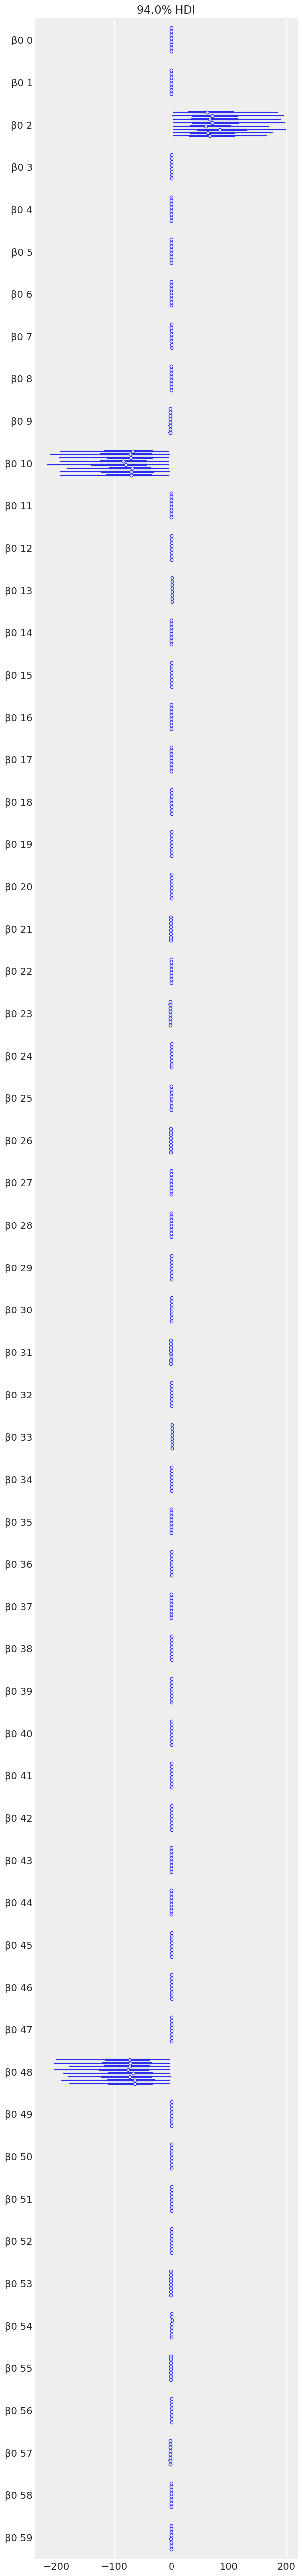

In [116]:
# Forest plots
plt.figure(figsize=(6,14))
with unpooled_model:
    pm.forestplot(unpooled_trace, var_names=['β0']);

Notice from these forest plots that some of the districs are underpopulated and not able to support estimates. Also notice in the plots of the logistic function for each district that they are highly variable and one of them is actually providing predicted probability of 1 for all ages.

In [123]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)
    sigma_b =  pm.HalfCauchy('sigma_b', 1e5)

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=ndistricts)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ndistricts)
    
    # Linear model
    μ = a[district] + b[district]*age
    
    # Transform outcome to probability
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=θ, observed=contraception)
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=1000, step=pm.NUTS(target_accept=0.99), tune=5000)



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, sigma_a, mu_b, mu_a]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 357 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9443035771771202, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


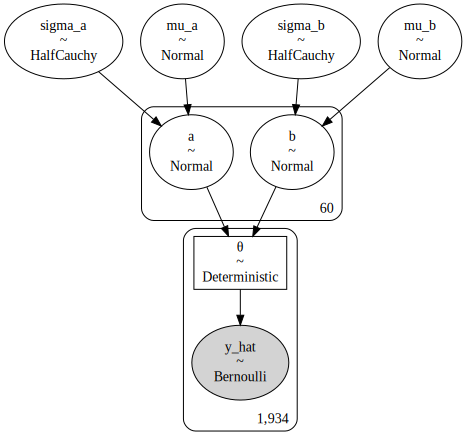

In [119]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchichal_model)

In [125]:
# Summary of results
with hierarchical_model:
    hierarchical_idata = az.from_pymc3(hierarchical_trace)
az.summary(hierarchical_idata, round_to=2, var_names = ['a','b'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.00,0.19,-1.35,-0.63,0.00,0.00,5622.11,5291.13,5651.29,2828.57,1.00
a[1],-0.60,0.36,-1.26,0.05,0.01,0.00,4987.47,3723.15,5009.35,2927.09,1.01
a[2],-0.22,0.50,-1.23,0.69,0.01,0.01,5214.57,2080.72,5328.89,2898.94,1.00
a[3],-0.19,0.30,-0.75,0.38,0.00,0.00,5748.10,2022.79,5736.42,2770.46,1.00
a[4],-0.58,0.28,-1.11,-0.06,0.00,0.00,5736.91,4020.31,5777.47,2586.96,1.00
a[5],-0.82,0.25,-1.26,-0.34,0.00,0.00,5075.56,5007.59,5050.73,3077.91,1.00
a[6],-0.75,0.37,-1.43,-0.06,0.01,0.00,4562.15,4055.61,4487.79,3299.00,1.00
a[7],-0.52,0.29,-1.06,0.02,0.00,0.00,6034.36,3943.92,6029.27,2650.88,1.00
a[8],-0.72,0.34,-1.38,-0.08,0.00,0.00,6017.98,4153.56,6004.22,2762.88,1.00
a[9],-1.17,0.45,-2.05,-0.37,0.01,0.01,4280.45,3029.89,4653.49,2104.35,1.00


<Figure size 600x1400 with 0 Axes>

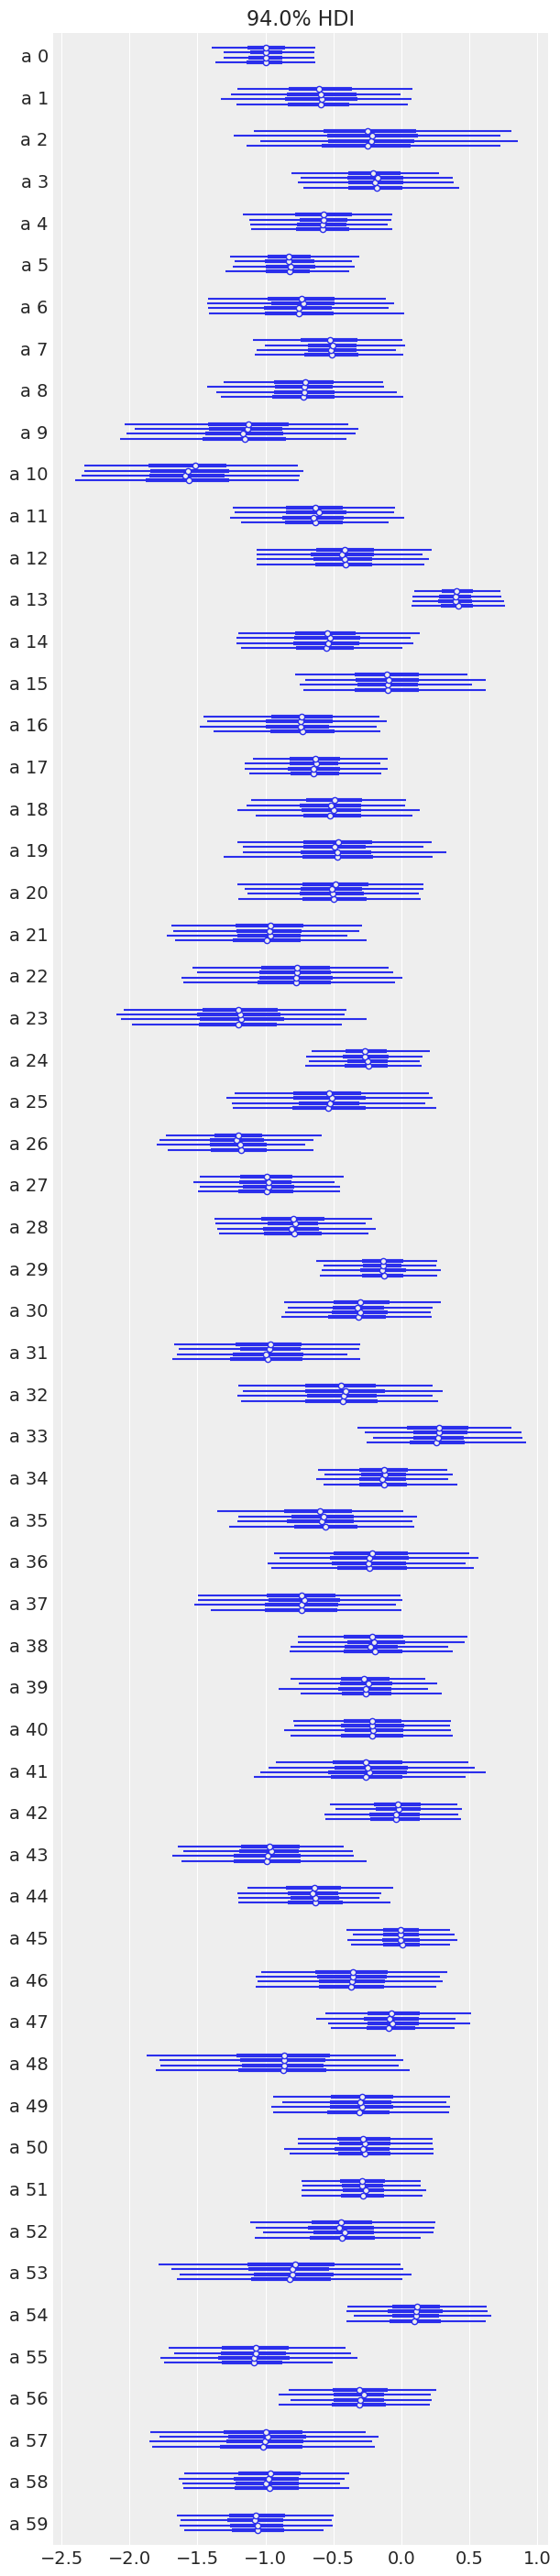

In [128]:
# Forest plots for intercepts
plt.figure(figsize=(6,14))
with hierarchical_model:
    pm.forestplot(hierarchical_trace, var_names=['a']);

<Figure size 600x1400 with 0 Axes>

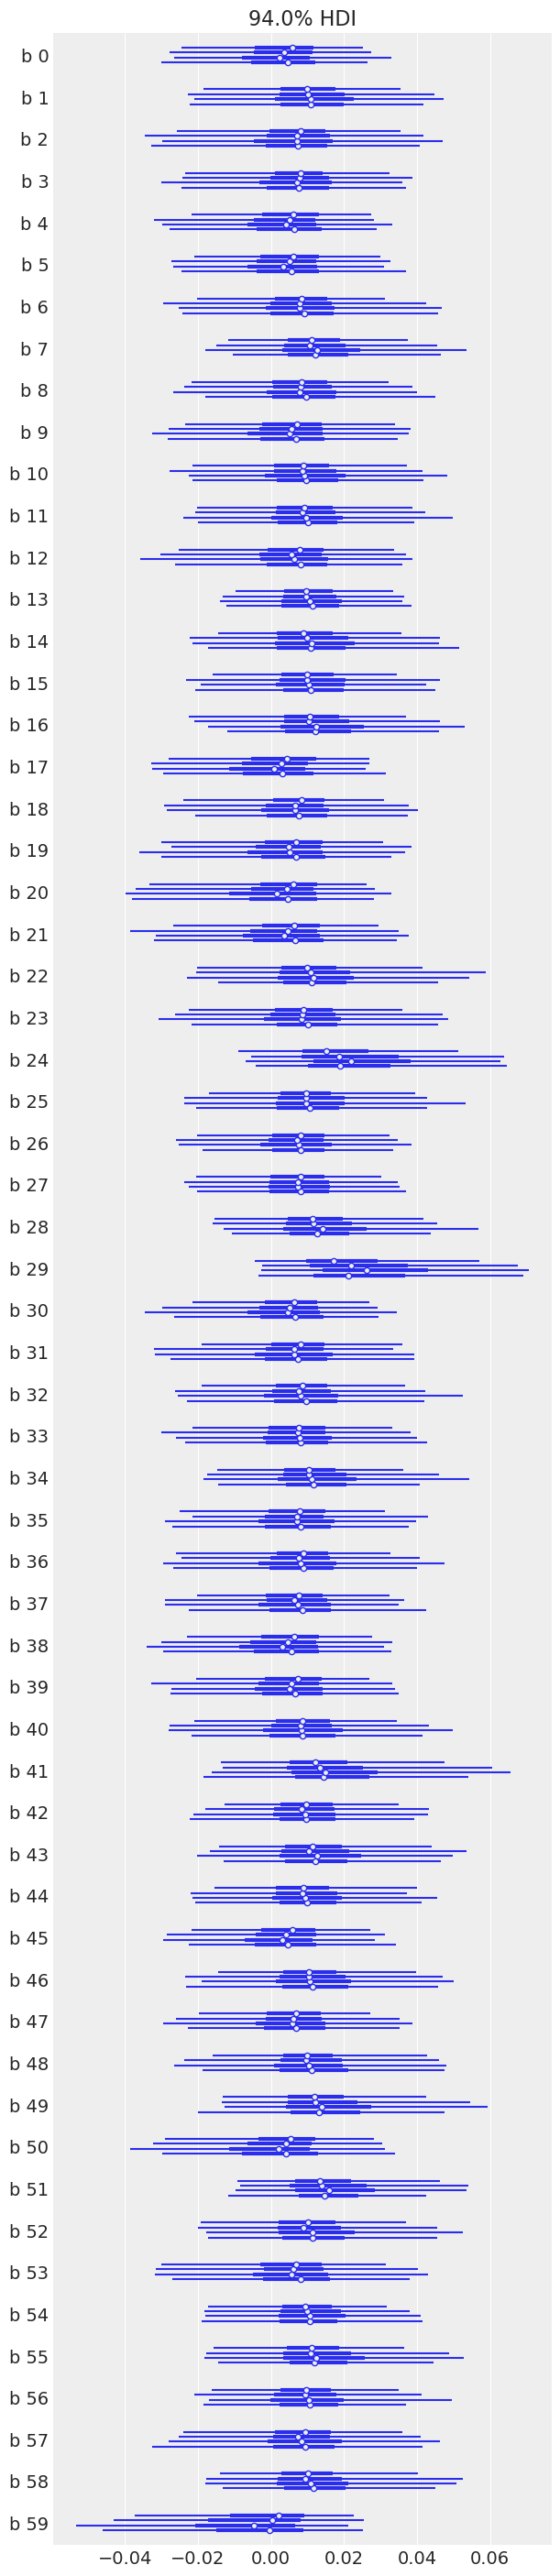

In [129]:
# Forest plots for slopes
plt.figure(figsize=(6,14))
with hierarchical_model:
    pm.forestplot(hierarchical_trace, var_names=['b']);

Text(0.5, 1.0, 'Hierarchical Model')

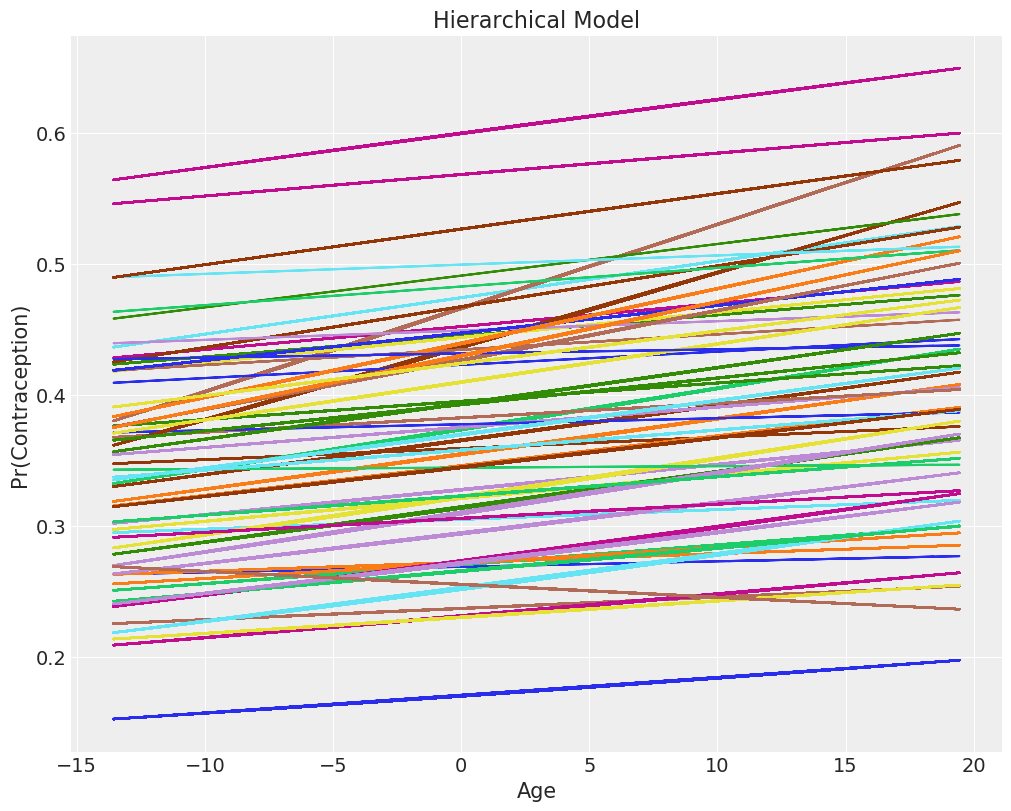

In [126]:
# Plot of the hierarchical model
intercepts = np.mean(hierarchical_trace['a'], axis=0)
slopes = np.mean(hierarchical_trace['b'], axis=0)
plt.figure(figsize = (10,8))
for ai, bi in zip(intercepts, slopes):
    plt.plot(age, logistic(ai + bi*age))

plt.xlabel("Age")
plt.ylabel("Pr(Contraception)")
plt.title("Hierarchical Model")

We can compare the probability of contraception for each of the models. For the pooled model this probability is 0.37 for the younger women and 0.42 for the older women regarless of district. In the unpooled model for one district this probability is 1.0 regardless of age, while in another district it is 0.0 regardless of age. Clearly these are not reasonable.  The hiearchical model provides models for each district with none that have extreme values due to the small sample size in the district. Probabilities of contraception use range from less than 0.2 (but greater than 0.1) in the district with the least useage to a range of (0.58, 0.62) in the district with the most useage.  

The forest plots show than none of the slope parameters are statistically significant at p < 0.05.  